<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 9: Spatial networks</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:

* OSMnx examples: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb
* Spaghetti: https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html

In [2]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1


In [2]:
!pip install haversine

In [4]:
!pip install spaghetti

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 17.9 MB/s eta 0:00:00


In [6]:
!pip install matplotlib_scalebar

In [7]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd

from haversine import haversine, haversine_vector

import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d

import matplotlib
import spaghetti
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline
ox.__version__

'1.9.4'

# Haversine distance

Always use the Haversine distance when calculating distances between far away points: https://github.com/mapado/haversine

In [8]:
copenhagen = (55.67594, 12.56553)  # (lat, lon)
london = (51.509865, -0.118092)
sanfrancisco = (37.773972, -122.431297)
newyork = (40.730610, -73.935242)

In [9]:
haversine(copenhagen, sanfrancisco)

8784.87818320771

In [10]:
haversine_vector(3*[copenhagen], [london, newyork, sanfrancisco])

array([ 954.68540063, 6182.52042412, 8784.87818321])

# Use OSMnx to calculate street network indicators

First we download the Frederiksberg drive network with OSMnx:

In [11]:
place = "Frederiksberg Municipality"
G = ox.graph_from_place(place, network_type="drive")
G_proj = ox.project_graph(G)

## Calculate basic street network measures (topological and geometric)

In [12]:
# Calculate Frederiksberg's basic stats, then show the average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

1.0271143003218066

To calculate density-based stats, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [13]:
# get the street network for a place, and its area in square meters
city = ox.geocode_to_gdf(place)
city_proj = ox.project_gdf(city)
area = city_proj.unary_union.area
area

8703103.63218525

In [14]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

,0
n,821
m,1952
k_avg,4.755177
edge_length_total,185215.034
edge_length_avg,94.884751
streets_per_node_avg,2.894032
streets_per_node_counts,"{0: 0, 1: 114, 2: 28, 3: 513, 4: 163, 5: 3}"
streets_per_node_proportions,"{0: 0.0, 1: 0.13885505481120586, 2: 0.03410475..."
intersection_count,707
street_length_total,109845.099


Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [15]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,821.000
m,1952.000
k_avg,4.755
edge_length_total,185215.034
edge_length_avg,94.885
streets_per_node_avg,2.894
intersection_count,707.000
street_length_total,109845.099
street_segment_count,1168.000
street_length_avg,94.045


### Inspect betweenness centrality

In [16]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

<ipython-input-16-10c31ccceda1>:2: FutureWarning: The `get_digraph` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_digraph` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")


(576734, 0.252428601209089)

In Frederiksberg Municipality, the node with the highest betweenness centrality has 25% of all shortest paths running through it. Let's highlight it in the plot:

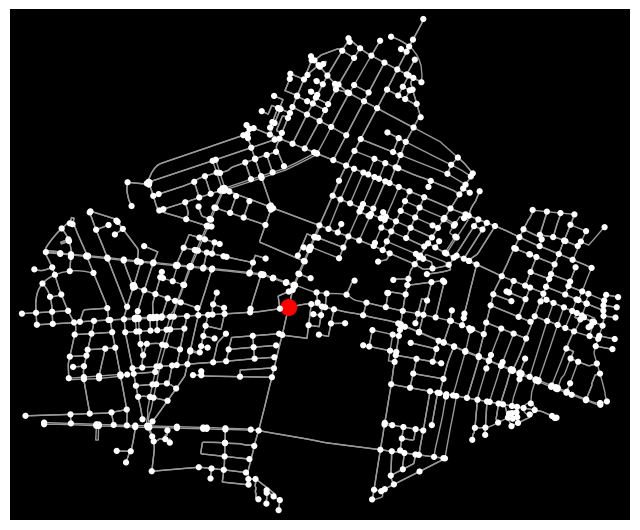

In [17]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [150 if node == max_node else 20 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor="k")

~25% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

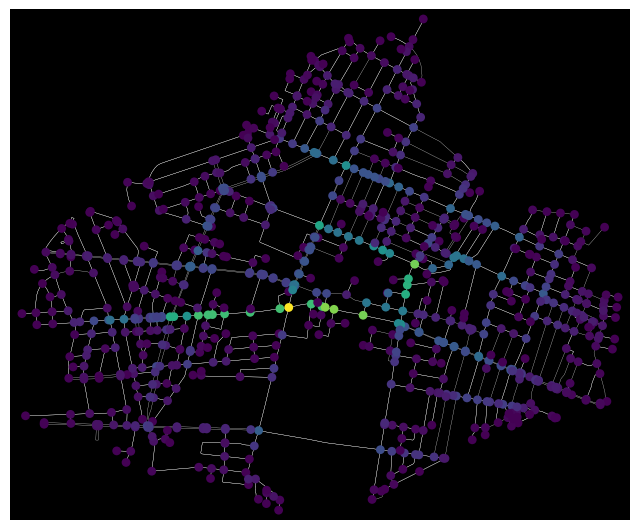

In [18]:
# add the betweenness centrality values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="viridis")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=40,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.

# Delaunay triangulation and Voronoi diagram

Let's showcase the Delaunay traingulation and the Voronoi diagram for pharmacies in Frederiksberg. In particular, the Voronoi diagram will tell us: What is the closest pharmacy to any location in Frederiksberg?

In [19]:
# Let's fetch all pharmacies and project them
tags = {'amenity': ['pharmacy']}
gdf_pharmacies = ox.geometries_from_place(place, tags=tags)
gdf_pharmacies = ox.project_gdf(gdf_pharmacies)
gdf_pharmacies

<ipython-input-19-a3c2e58a2196>:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_pharmacies = ox.geometries_from_place(place, tags=tags)


amenity check_date:opening_hours healthcare  \
element_type osmid                                                       
node         2955867754   pharmacy               2024-06-23   pharmacy   
             4886221183   pharmacy                      NaN   pharmacy   
             6579860143   pharmacy                      NaN   pharmacy   
             6959994877   pharmacy                      NaN   pharmacy   
             7144688116   pharmacy               2023-10-03        NaN   
             8254386587   pharmacy                      NaN   pharmacy   
             8367053969   pharmacy                      NaN   pharmacy   
             9089831028   pharmacy                      NaN   pharmacy   
             10908694871  pharmacy                      NaN        NaN   

                                               name  \
element_type osmid                                    
node         2955867754     Dalgas Boulevard Apotek   
             4886221183            Apoteket Godthåb   
             6579860143          Smallegades Apotek   
             6959994877                    Apoteket   
             7144688116               Apotek Ørsted   
             8254386587          Apotek Borups Allé   
             8367053969   Frederiksberg Løve Apotek   
             9089831028        Frederiksberg Apotek   
             10908694871             Fasan Apoteket   

                                                              opening_hours  \
element_type osmid                                                            
node         2955867754   Mo-Th 09:00-17:30; Fr 09:00-18:00; Sa 09:30-13:30   
             4886221183                   Mo-Fr 09:00-19:00; Sa 09:30-16:00   
             6579860143   08:00-17:30; Sa 09:00-13:30; Su off; Jan 1 off...   
             6959994877                                                 NaN   
             7144688116                                   Mo-Sa 09:00-18:00   
             8254386587                                         08:00-20:00   
             8367053969                Mo-Fr 10:00-19:00; Sa-Su 10:00-17:00   
             9089831028                   Mo-Fr 09:30-18:00; Sa 09:30-14:00   
             10908694871                                                NaN   

                         toilets:wheelchair  \
element_type osmid                            
node         2955867754                  no   
             4886221183                 NaN   
             6579860143                 NaN   
             6959994877                 NaN   
             7144688116                 NaN   
             8254386587                 NaN   
             8367053969                 NaN   
             9089831028                 NaN   
             10908694871                NaN   

                                                                    website  \
element_type osmid                                                            
node         2955867754   https://www.apoteket.dk/apoteker/frederiksberg...   
             4886221183                                                 NaN   
             6579860143                   https://smallegade.apotekeren.dk/   
             6959994877                                                 NaN   
             7144688116                                                 NaN   
             8254386587                                                 NaN   
             8367053969   https://www.apoteket.dk/apoteker/vanloese-loev...   
             9089831028   https://apoteket-online.dk/apotek/frederiksber...   
             10908694871  https://www.apoteket.dk/apoteker/koebenhavn-ap...   

                         wheelchair                        geometry  \
element_type osmid                                                    
node         2955867754         yes  POINT (343488.521 6173461.280)   
             4886221183          no  POINT (345229.807 6173831.459)   
             6579860143         yes  POINT (344297.368 6173210.5

In [20]:
# Let's extract the coordinates
pharmacies_coords = np.vstack((
    np.array(gdf_pharmacies.geometry.x),
    np.array(gdf_pharmacies.geometry.y)
)).T
pharmacies_coords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 343488.52137855, 6173461.27954614],
       [ 345229.80663513, 6173831.45918688],
       [ 344297.36826902, 6173210.5565033 ],
       [ 344800.94761035, 6173377.78158292],
       [ 345873.15652438, 6173198.92544987],
       [ 344958.79160712, 6174746.86613936],
       [ 345292.19260676, 6173817.51436977],
       [ 345066.58541096, 6172979.16380171],
       [ 344223.38678955, 6173422.25588895]])

## Delaunay triangulation

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


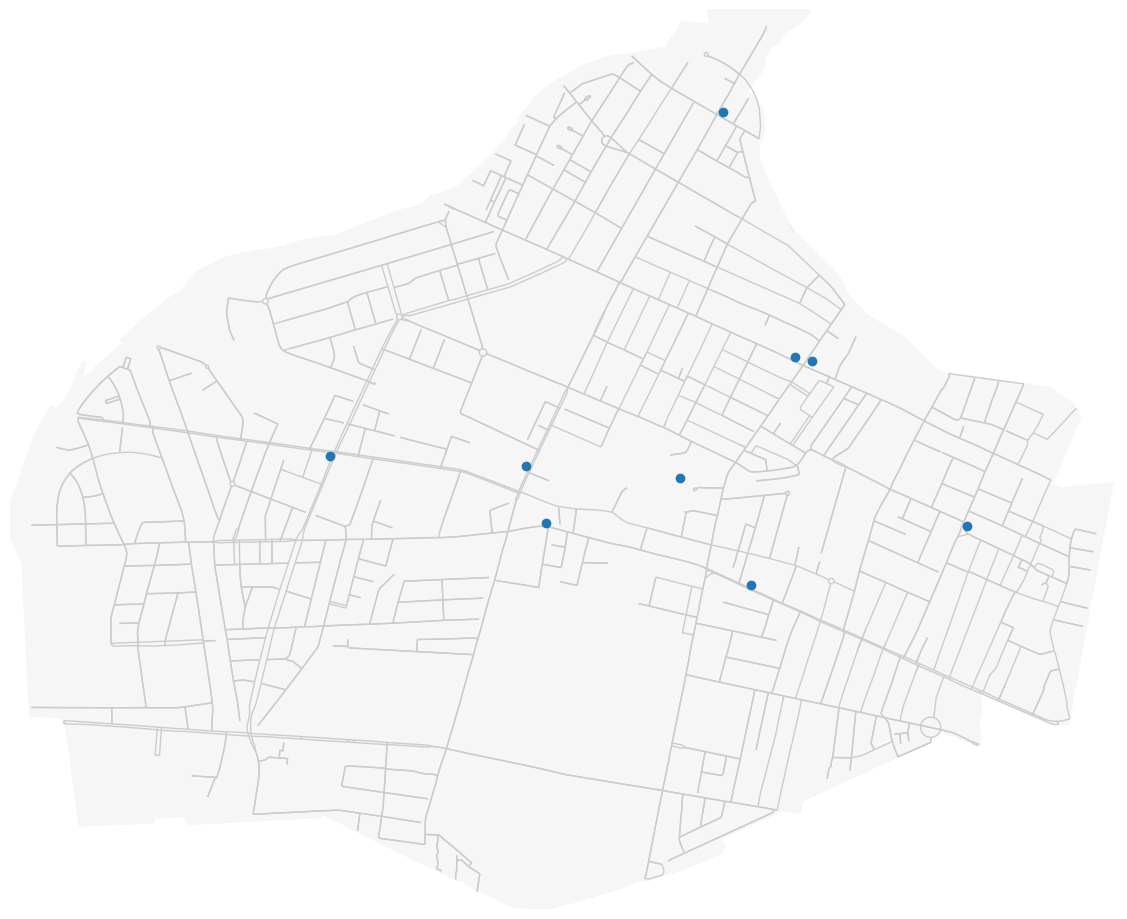

In [21]:
tri = Delaunay(pharmacies_coords)
fig = plt.figure(figsize=(12, 9))
axes = fig.add_axes([0, 0, 1, 1])
delaunay_plot_2d(tri, ax=axes);

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes, edge_color="#CCCCCC");

## Voronoi diagram

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


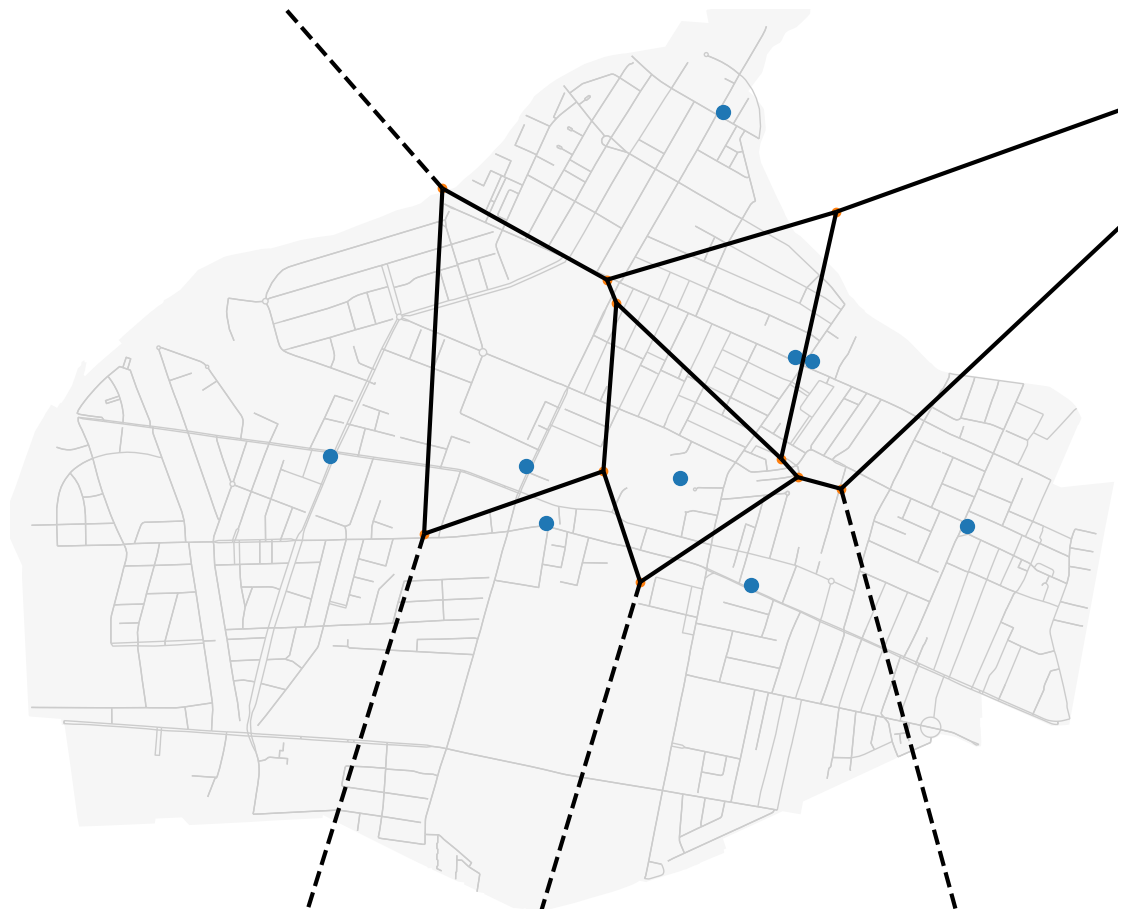

In [22]:
vor = Voronoi(pharmacies_coords)
fig = plt.figure(figsize=(12, 9))
axes = fig.add_axes([0, 0, 1, 1])
voronoi_plot_2d(vor, ax=axes, line_width = 3, point_size=20);

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes, edge_color="#CCCCCC");

Voila! The thick black lines show us the areas closest to each pharmacy (blue).

# Network-constrained spatial clustering with Ripley's K using Spaghetti

Ripley's K function takes a point pattern and considers all pairwise distances of nearest neighbors to determine the existence of clustering, or lack thereof, over a delineated range of distances: https://en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley's_K_and_L_functions

However, using Ripley's K for urban amenities is wrong: Amenities cannot be reached as the crow flies -you can't move through buildings-, but only over the street network. The Spaghetti package is part of PySAL - it allows to constrain spatial dependence to a street network: https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html It combines point pattern analysis with spatial networks. It has tools to snap points to a network and to analyze point patterns constrained to the network, which can be very useful for asking questions like "How clustered are pubs/pharmacies *on the street network*?"

We want to analyze two point of interest (POI) datasets in Frederiksberg: 1) Pubs+Restaurants, and 2) Pharmacies (from above). Let's fetch and project the new dataset, pubs+restaurants:

In [23]:
tags = {'amenity': ['pub', 'restaurant']}
gdf_pubs = ox.geometries_from_place(place, tags=tags)
gdf_pubs = ox.project_gdf(gdf_pubs)
gdf_pubs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-23-fc0ef8db8cbc>:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_pubs = ox.geometries_from_place(place, tags=tags)


amenity fvst:navnelbnr                  name  \
element_type osmid                                                          
node         277694702           pub         115321           Cafe Intime   
             277703258           pub         111210            Alléenberg   
             278380921           pub         921122            Cafe Svejk   
             278389273           pub         738934            Promenaden   
             279143638    restaurant         115050          Viet Nam Nam   
...                              ...            ...                   ...   
             12069242530         pub        1388783             Marstrand   
             12069255446  restaurant            NaN  Sushi & Asian Bistro   
             12071658272  restaurant            NaN                   Yue   
             12074935474  restaurant            NaN             Pizza Hut   
             12076124817  restaurant            NaN                   NaN   

                                                              opening_hours  \
element_type osmid                                                            
node         277694702                                  Mo-Su 16:00 - 02:00   
             277703258                                    Tu-Sa 22:00-05:00   
             278380921                  Su-Mo 12:00-24:00;Tu-Sa 12:00-02:00   
             278389273    Mo-We 11:00-23:00; Th-Sa 11:00-24:00; Su 11:00...   
             279143638                                          16:00-23:00   
...                                                                     ...   
             12069242530               Su-Th 11:00-23:00, Fr,Sa 11:00-24:00   
             12069255446                                                NaN   
             12071658272                                  Mo-Su 12:00-22:00   
             12074935474                                                NaN   
             12076124817                                                NaN   

                                    phone ref:DK:cvr ref:DK:cvr:pnummer  \
element_type osmid                                                        
node         277694702    +45 38 34 19 58   27979440         1010696328   
             277703258       +45 33254442   25689097         1007991440   
             278380921       +45 38862560   40692932         1024914271   
             278389273                NaN   39126680         1023555944   
             279143638                NaN   54395957         1014630240   
...                                   ...        ...                ...   
             12069242530              NaN   40782869         1029309694   
             12069255446              NaN        NaN                NaN   
             12071658272              NaN        NaN                NaN   
             12074935474              NaN   44325233                NaN   
             12076124817              NaN        NaN                NaN   

                         toilets                     website   wikidata  ...  \
element_type osmid                                                       ...   
node         277694702       yes   http://www.cafeintime.dk/  Q12305023  ...   
             277703258       yes  https://www.alleenberg.dk/        NaN  ...   
             278380921       NaN                         NaN        NaN  ...   
             278389273       NaN                         NaN        NaN  ...   
             279143638       NaN  http://www.viet-namnam.dk/        NaN  ...   
...                          ...                         ...        ...  ...   
             12069242530     NaN                         NaN        NaN  ...   
             12069255446     NaN                         NaN        NaN  ...   
             12071658272     NaN    https://www.yuensbar.dk/        NaN  ...   
             12074935474     NaN                         NaN        NaN  ...   
             12076124817     NaN                         NaN   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


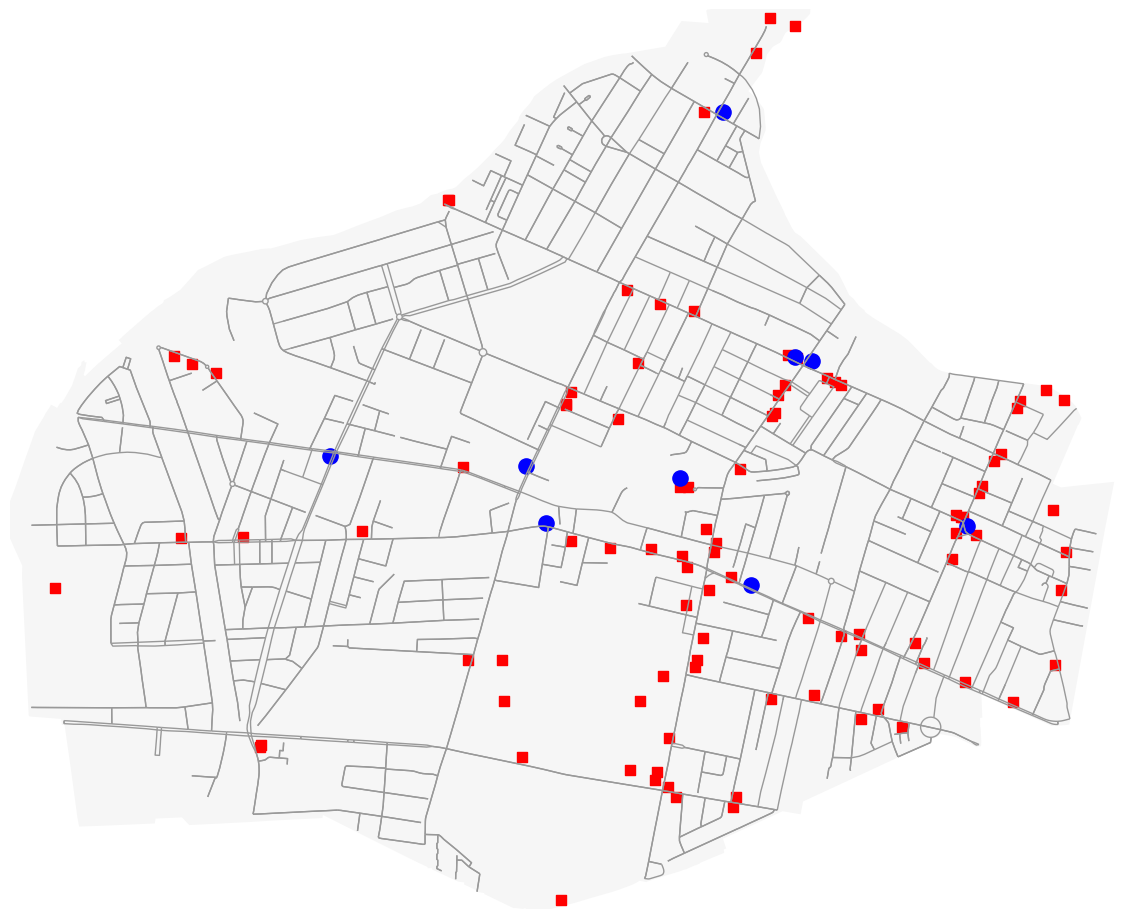

In [24]:
fig = plt.figure(figsize=(12, 9))
axes = fig.add_axes([0, 0, 1, 1])

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot the two POI datasets
gdf_pubs.plot(ax=axes, color="r", markersize=60, marker="s")
gdf_pharmacies.plot(ax=axes, color="b", markersize=120)

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes);

We first need a helper function for nice plotting (adapted from https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html#Results-plotting-helper-function)

In [25]:
def plot_k(k, _arcs, df1, df2, obs, scale=True, wr=[1, 1.2], size=(14, 7)):
    """Plot a Global Auto K-function and spatial context."""
    def function_plot(f, ax):
        """Plot a Global Auto K-function."""
        ax.plot(k.xaxis, k.observed, "b-", linewidth=1.5, label="Observed")
        ax.plot(k.xaxis, k.upperenvelope, "r--", label="Upper")
        ax.plot(k.xaxis, k.lowerenvelope, "k--", label="Lower")
        ax.legend(loc="best", fontsize="x-large")
        title_text = "Global Auto $K$ Function: %s\n" % obs
        title_text += "%s steps, %s permutations," % (k.nsteps, k.permutations)
        title_text += " %s distribution" % k.distribution
        f.suptitle(title_text, fontsize=25, y=1.1)
        ax.set_xlabel("Distance $(r)$", fontsize="x-large")
        ax.set_ylabel("$K(r)$", fontsize="x-large")

    def spatial_plot(ax):
        """Plot spatial context."""
        base = _arcs.plot(ax=ax, color="k", alpha=0.25)
        df1.plot(ax=base, color="g", markersize=30, alpha=0.25)
        df2.plot(ax=base, color="g", marker="x", markersize=100, alpha=0.5)
        carto_elements(base, scale)

    sub_args = {"gridspec_kw":{"width_ratios": wr}, "figsize":size}
    fig, arr = matplotlib.pyplot.subplots(1, 2, **sub_args)
    function_plot(fig, arr[0])
    spatial_plot(arr[1])
    fig.tight_layout()

def carto_elements(b, scale):
    """Add/adjust cartographic elements."""
    if scale:
        kw = {"units":"m", "dimension":"si-length", "fixed_value":1000}
        b.add_artist(ScaleBar(1, **kw))
    b.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Because spaghetti has no OSMnx integration, we need to use shapefiles for example. We therefore export the graph, so that we can import it later as a spaghetti.Network

In [26]:
ox.io.save_graph_shapefile(G_proj, "Frederiksberg")

<ipython-input-26-c4d234a46f86>:1: FutureWarning: The `save_graph_shapefile` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.io.save_graph_shapefile(G_proj, "Frederiksberg")
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to 

Now we build the spaghetti.Network from the shape file:

In [27]:
ntw = spaghetti.Network(in_data="Frederiksberg/edges.shp")
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/libpysal/io/iohandlers/pyShpIO.py:247: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  shp = self.type(vertices)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _O

Snapping pubs and pharmacies to our street network, creating two pointpatterns on the network:

In [28]:
ntw.snapobservations(gdf_pubs, "pubs", attribute=True)
ntw.snapobservations(gdf_pharmacies, "pharmacies", attribute=True)
ntw.pointpatterns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/usr/local/lib/python3.10/dist-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a 

{'pubs': <spaghetti.network.PointPattern at 0x7d4243e95a50>,
 'pharmacies': <spaghetti.network.PointPattern at 0x7d4244d39de0>}

Saving the pointpatterns and their snapped versions as gdf, for plotting later:

In [29]:
pubs = spaghetti.element_as_gdf(ntw, pp_name="pubs")
pubs_snapped = spaghetti.element_as_gdf(ntw, pp_name="pubs", snapped=True)
pharmacies = spaghetti.element_as_gdf(ntw, pp_name="pharmacies")
pharmacies_snapped = spaghetti.element_as_gdf(ntw, pp_name="pharmacies", snapped=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Clustering of pubs and restaurants

Running Ripley's K for pubs *on the network* (this can take around 2 minutes):

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


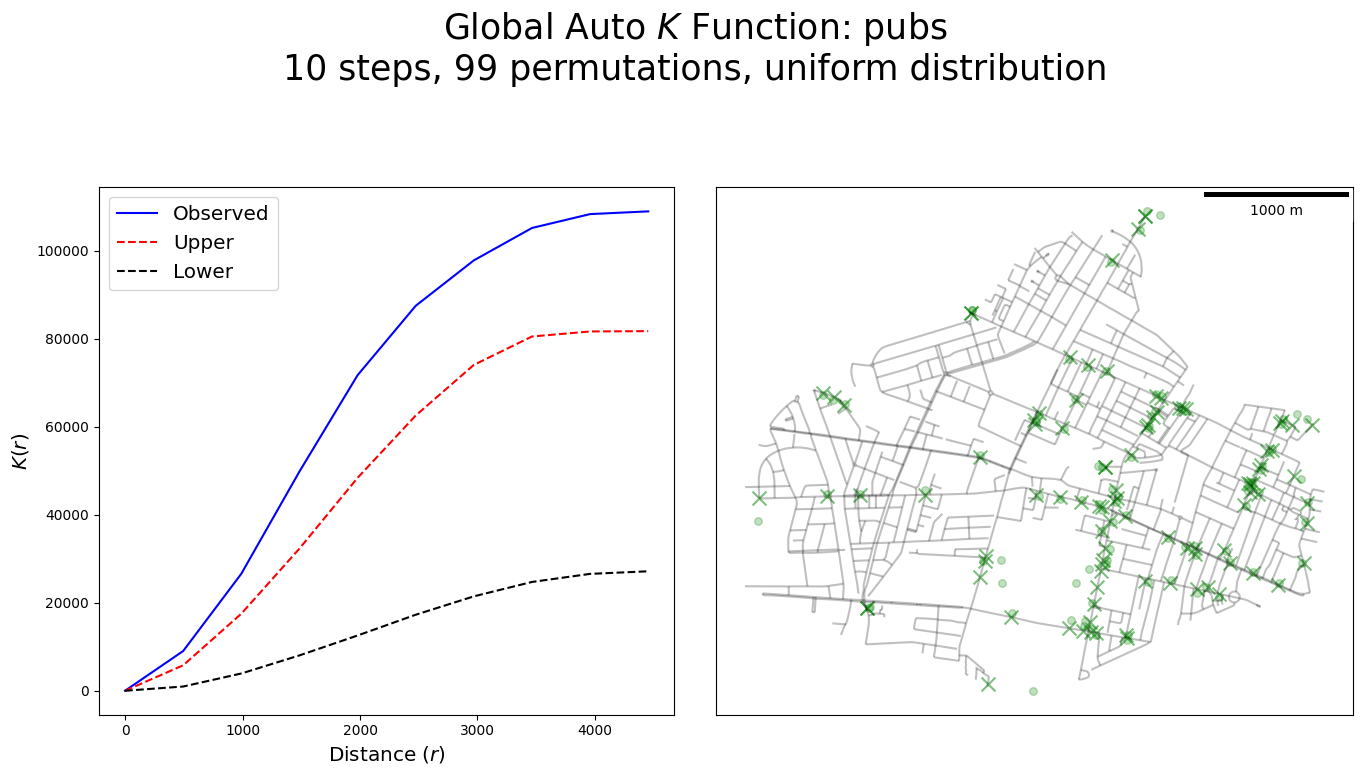

In [30]:
np.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["pubs"],
    nsteps=10,
    permutations=99) # Keep permutations low here, otherwise too much time needed for computation
plot_k(kres, arcs_df, pubs, pubs_snapped, "pubs")

### Interpretation

Because the observed curve is always above the simulation envelope, pubs+restaurants are clustered on the street network **on all scales**!

It looks like a showcase for economies of agglomeration or business cluster effects, especially Gammel Kongevej and Pile Alle/Falkoner Alle:  
https://en.wikipedia.org/wiki/Economies_of_agglomeration https://en.wikipedia.org/wiki/Business_cluster#Cluster_effect

## Clustering of pharmacies

Now let's run Ripley's K on the pharmacies. This is much faster due to the low number of points, so we can crank up the parameters:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


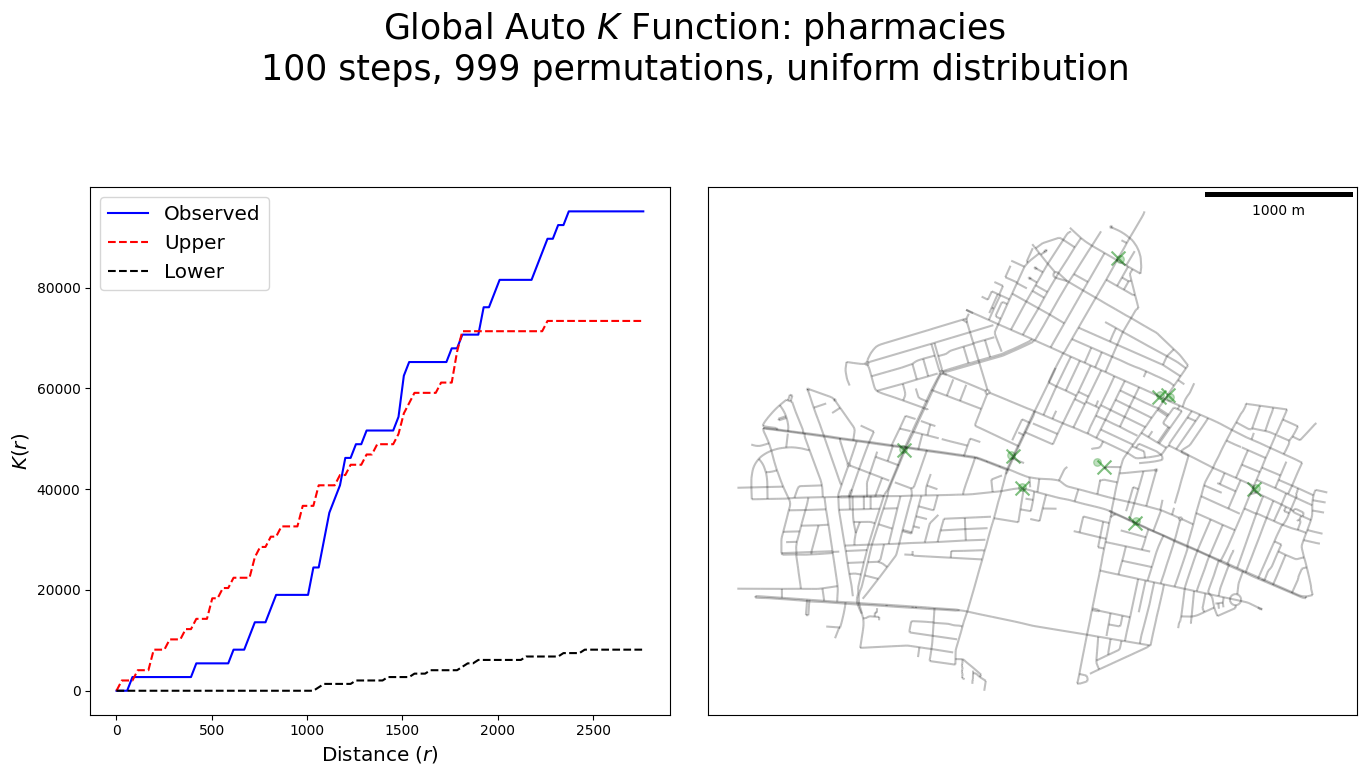

In [31]:
np.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["pharmacies"],
    nsteps=100,
    permutations=999)
plot_k(kres, arcs_df, pharmacies, pharmacies_snapped, "pharmacies")

### Interpretation

Pharmacies show different clustering behavior than pubs+restaurants. If it wasn't for those two pharmacies in the north east right next to each other, their observed curve would be on the lowest end of the simulation envelope for low distances, showing that they are quite dispersed on short ranges. Maybe there are minimum distance laws in place to make pharmacies cover the city well? On the other hand, for distances above 2km, the observed curve is above the envelope, meaning clustering. On this scale, pharmacies are clustered in the east, and there is quite some empty space in the north west and south west of Frederiksberg.